This will be a hybrid deep learning model.
In step one we will use self organizing map to identify fraud customers and 
in the second step we will use neural network to rank custmers with probability of fraud.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv("./data/Credit_Card_Applications.csv")
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

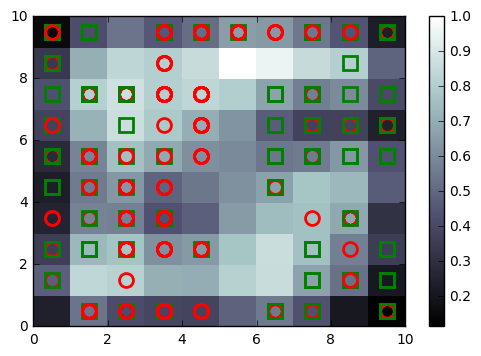

In [4]:
#Build a SOM & Fit the data

from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = X.shape[1], sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)
#Visualize the result
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor= 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

In [12]:
#Find the frauds
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(4,7)], mappings[(2,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [13]:
print(frauds) #All the customer IDs that potentially cheated

[[  1.55943050e+07   0.00000000e+00   2.37500000e+01   7.10000000e-01
    2.00000000e+00   9.00000000e+00   4.00000000e+00   2.50000000e-01
    0.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    2.00000000e+00   2.40000000e+02   5.00000000e+00]
 [  1.56647930e+07   0.00000000e+00   1.73300000e+01   9.50000000e+00
    2.00000000e+00   6.00000000e+00   4.00000000e+00   1.75000000e+00
    0.00000000e+00   1.00000000e+00   1.00000000e+01   1.00000000e+00
    2.00000000e+00   0.00000000e+00   1.10000000e+01]
 [  1.56700290e+07   0.00000000e+00   1.69200000e+01   5.00000000e-01
    2.00000000e+00   3.00000000e+00   4.00000000e+00   1.65000000e-01
    0.00000000e+00   1.00000000e+00   6.00000000e+00   1.00000000e+00
    2.00000000e+00   2.40000000e+02   3.60000000e+01]
 [  1.57635790e+07   0.00000000e+00   1.60000000e+01   1.65000000e-01
    2.00000000e+00   6.00000000e+00   4.00000000e+00   1.00000000e+00
    0.00000000e+00   1.00000000e+00   2.00000000e+00   1.00000000e+0

In [14]:
#Now change this as supervised deep learning model - what we need is to use label.
#Create a matrix of features

customer_features = dataset.iloc[:, 1:].values #Features except first customer ID column

#Create labels
is_fraud = np.zeros(len(dataset)) #This will be label having 1 or 0 depending customer is fraud or not.
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_fraud[i] = 1

In [16]:
print(is_fraud[:20])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(customer_features)
y_train = is_fraud

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [19]:
classifier = Sequential()
classifier.add(Dense(output_dim=2, init = 'uniform', activation = 'relu', input_dim = 15))
classifier.add(Dense(output_dim=6, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim=1, init = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 1, nb_epoch = 2)

Epoch 1/2
690/690 [==============================] - 3s - loss: 0.3172 - acc: 0.9754           

In [40]:
#time to make prediction - probabilities of the fraud
y_pred = classifier.predict(customer_features)

In [42]:
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis=1) # Add customer Id and predicted proba together

In [43]:
print(y_pred[:10,])

[[  1.57761560e+07   1.68282181e-01]
 [  1.57395480e+07   5.59920620e-04]
 [  1.56628540e+07   9.65418508e-07]
 [  1.56876880e+07   3.42781641e-05]
 [  1.57157500e+07   6.08422002e-03]
 [  1.55711210e+07   3.90496803e-03]
 [  1.57264660e+07   1.68282181e-01]
 [  1.56603900e+07   1.68282181e-01]
 [  1.56639420e+07   1.68282181e-01]
 [  1.56386100e+07   1.65591389e-02]]


In [44]:
#Sort the prediction on probability
y_pred = y_pred[y_pred[:, 1].argsort()]

In [45]:
print(y_pred[:10,])

[[  1.56058720e+07   0.00000000e+00]
 [  1.57067620e+07   1.61367445e-26]
 [  1.57882150e+07   2.29071030e-21]
 [  1.55933450e+07   7.99976193e-20]
 [  1.57131600e+07   2.14560076e-16]
 [  1.57739340e+07   2.06810167e-15]
 [  1.57163470e+07   4.49545584e-15]
 [  1.57853390e+07   1.24688722e-14]
 [  1.56086880e+07   1.02572458e-13]
 [  1.57297710e+07   5.24309003e-13]]
